In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchio as tio
from torchsummary import summary


In [ ]:

class conv_block(nn.Module):
    def __init__(self,ch_in : int,ch_out : int, dropout : float= 0.) -> None:
        super(conv_block,self).__init__()
        layers = [
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        ]
        if dropout != 0.:
            layers.append(nn.Dropout(p=dropout))
        self.conv = nn.Sequential(*layers)



    def forward(self,x : torch.Tensor)-> torch.Tensor:
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in: int,ch_out: int, dropout: float= 0.) -> None:
        super(up_conv,self).__init__()
        self.conv = conv_block(ch_in= int(ch_in/2), ch_out= ch_out)
        layers = [
            nn.ConvTranspose2d(ch_in,ch_out, kernel_size=2,stride=2),
            
        ]

        self.up = nn.Sequential(*layers)


    def forward(self,x : torch.Tensor) -> torch.Tensor:
        x = self.up(x)
        # print(x.shape)
        x = self.conv(x)
        return x

In [ ]:


class AutoEncoder(nn.Module):
    def __init__(self,img_ch: int = 3,output_ch: int = 1, dropout: float = 0., depth: int= 5) -> None:
        super(AutoEncoder,self).__init__()
        self.output_ch = output_ch
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Conv1 = conv_block(ch_in= img_ch, ch_out= 64, dropout= dropout)
        self.Conv2 = conv_block(ch_in= 64, ch_out= 128, dropout= dropout)
        self.Conv3 = conv_block(ch_in= 128, ch_out= 256, dropout= dropout)
        self.Conv4 = conv_block(ch_in= 256, ch_out= 512, dropout= dropout)
        self.Conv5 = conv_block(ch_in= 512, ch_out= 1024, dropout= dropout)

        self.Up5 = up_conv(ch_in= 1024, ch_out= 512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512,dropout= dropout)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256,dropout= dropout)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128,dropout= dropout)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64,dropout= dropout)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def encoder(self, x: torch.Tensor) -> torch.Tensor:
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        return x5
    
    def decoder(self, x: torch.Tensor) -> torch.Tensor:
        # print(x.shape)
        d5 = self.Up5(x)
        # print("d5",d5.shape)
        d4 = self.Up4(d5)
        d3 = self.Up3(d4)
        d2 = self.Up2(d3)
        d1 = self.Conv_1x1(d2)
        # d1 = self.relu(d1)
        return d1
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        encoded = encoded.to('cuda')
        return self.decoder(encoded)

unet =  AutoEncoder(img_ch=1,output_ch=1, dropout=0.).to('cuda')
# summary(unet,(1,256,256))


In [ ]:
import os
import numpy as np
import torch
# Fix memory problem
torch.cuda.empty_cache()
import torchvision
from torch import optim
from utils_metrics import AverageMeter, EarlyStopping
import csv
from tqdm import tqdm
from torch.utils import data
from Multiorgan.utils import build_model

In [ ]:
from datetime import datetime
# Hyperparameters
MODEL_TYPE = "AutoEncoder"
NUM_EPOCHS = 200
BATCH_SIZE = 4
GLOBAL_STEP = 0

lr = 0.01
beta1 = 0.5
beta2 = 0.999
early_patience = 30
lr_patience = 5
dropout = 0
# Saving Parameters
day, month = datetime.date(datetime.now()).day, datetime.date(datetime.now()).month
classes= ["BACKGROUND", "RECTUM","VESSIE","TETE_FEMORALE_D", "TETE_FEMORALE_G"]
device = 'cuda'
result_path = f'c:\\Users\\ek779475\\Documents\\Koutoulakis\\automatic_segmentation\\networks\\result\\{MODEL_TYPE}\\{day}_{month}_{NUM_EPOCHS}_{BATCH_SIZE}'
# Dataset
image_size =256
num_workers = 4
train_path='C:\\Users\\ek779475\\Desktop\\PRO_pCT_CGFL\\multiclass\\train'
valid_path='C:\\Users\\ek779475\\Desktop\\PRO_pCT_CGFL\\multiclass\\validation'
unet_path = os.path.join(
			result_path,
			'checkpoint.pkl'
		)
if not os.path.exists(result_path):
	os.makedirs(result_path)
# c:\\Users\\ek779475\\Documents\\Koutoulakis\\automatic_segmentation\\networks\\result\\AutoEncoder\\17_3_200_4



In [ ]:

from loaders.data_loader import get_loader
def class_mapping(classes):
	""" Maps the classes according to the pixel are shown into the mask
	"""
	mapping_dict={}
	for index,i in enumerate(classes):
		
		if index == 0:
			mapping_dict[0]= index
		else:
			mapping_dict[int(255/index)]= index
	return mapping_dict
classes = class_mapping(classes)
    
train_loader = get_loader(image_path=train_path,
                        image_size=image_size,
                        batch_size=BATCH_SIZE,
                        num_workers=num_workers,
                        classes = classes,
                        mode='train')
valid_loader = get_loader(image_path=valid_path,
                        image_size=image_size,
                        batch_size=BATCH_SIZE,
                        num_workers=num_workers,
                        classes = classes,
                        mode='valid')


In [ ]:

unet =  AutoEncoder(img_ch=1,output_ch=1, dropout=0.).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(
			list(unet.parameters()), lr,
			[beta1, beta2],weight_decay=1e-5)
sheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min", patience=lr_patience, 
			verbose=True,min_lr = 1e-6)
early_stopping = EarlyStopping(patience=early_patience, verbose=True, path=unet_path)



In [ ]:
import matplotlib.pyplot as plt
def epoch_train(model,train_loader, val_loader,epoch):
	model.train(True)
	n_train = len(train_loader)
	train_loss=np.array([])
	
	with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', unit='img') as pbar:
		for i, (image, _) in enumerate(train_loader):
			image = image.to(device,dtype=torch.float32)
			# assert image.shape[1] == img_ch, f'Network has been defined with {img_ch} input channels'
			optimizer.zero_grad(set_to_none=True)
			# with torch.cuda.amp.autocast(enabled=self.amp):

			output = model(image)
			output = torch.sigmoid(output)
			loss = criterion(output,image)
			train_loss = np.append(train_loss,loss.item())
			
			# Backprop + optimize
			loss.backward()
			optimizer.step()
			pbar.update(int(image.shape[0]/BATCH_SIZE))
			# GLOBAL_STEP +=1
			

			pbar.set_postfix(**{'loss (batch)': loss.item()})
		print(f"[Training] Avg loss = {train_loss.mean()}")



	# Validation
	model.train(False)
	model.eval()
	val_loss = np.array([])
	for (image, _) in tqdm(
		valid_loader, 
		total = len(valid_loader), 
		desc="Validation Round", 
		unit="batch", 
		leave=False):

		image = image.to(device,dtype=torch.float32)
		with torch.no_grad():		
			pred = model(image)
			pred = torch.sigmoid(pred)
			loss = criterion(pred,image)
			val_loss = np.append(val_loss,loss.item())
	
	fig, (ax1,ax2) = plt.subplots(1,2)
	ax1.imshow(pred.data.cpu()[0].squeeze(), cmap="gray")
	ax2.imshow(image.data.cpu()[0].squeeze(), cmap="gray")
	plt.show()
	print(f"[Validation] Avg loss = {val_loss.mean()}")

	lr = optimizer.param_groups[0]['lr']
	sheduler.step(val_loss.mean())
	early_stopping(val_loss.mean(),model)

Epoch 40/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00429]


[Training] Avg loss = 0.004851553839926523


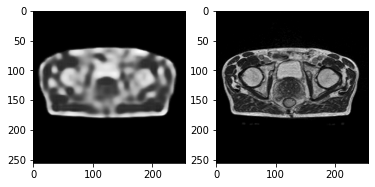

[Validation] Avg loss = 0.005195841058726013
Validation loss decreased (0.005247 --> 0.005196).  Saving model ...


Epoch 41/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00426]


[Training] Avg loss = 0.004829215885725077


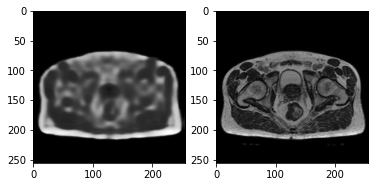

[Validation] Avg loss = 0.005761099137095335
EarlyStopping counter: 1 out of 30


Epoch 42/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00498]


[Training] Avg loss = 0.00485733564299597


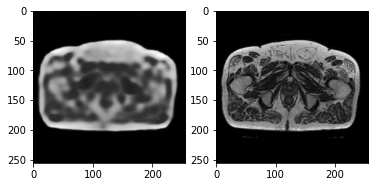

[Validation] Avg loss = 0.005288653389209568
EarlyStopping counter: 2 out of 30


Epoch 43/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.10img/s, loss (batch)=0.00528]


[Training] Avg loss = 0.004842333326925506


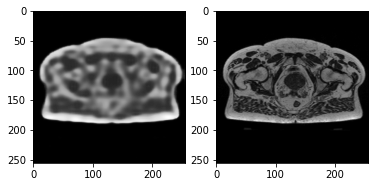

[Validation] Avg loss = 0.00520208807010511
EarlyStopping counter: 3 out of 30


Epoch 44/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00512]


[Training] Avg loss = 0.004830716079526475


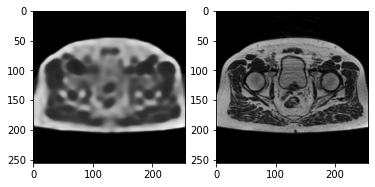

[Validation] Avg loss = 0.005266261416127776
EarlyStopping counter: 4 out of 30


Epoch 45/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00659]


[Training] Avg loss = 0.004836930854252278


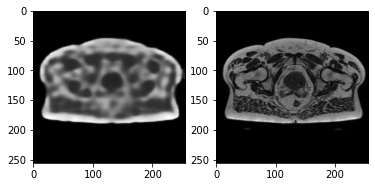

[Validation] Avg loss = 0.005206235742854206
EarlyStopping counter: 5 out of 30


Epoch 46/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00487]


[Training] Avg loss = 0.004841866619073581


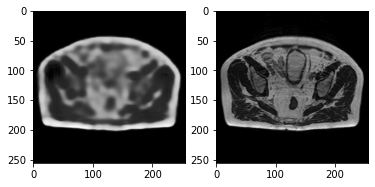

[Validation] Avg loss = 0.005422922034929245
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 30


Epoch 47/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00494]


[Training] Avg loss = 0.004812768160147553


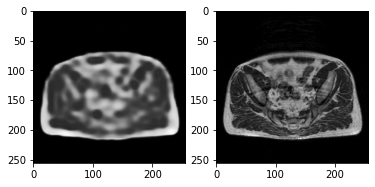

[Validation] Avg loss = 0.0051719983009984195
Validation loss decreased (0.005196 --> 0.005172).  Saving model ...


Epoch 48/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00385]


[Training] Avg loss = 0.004798368282547306


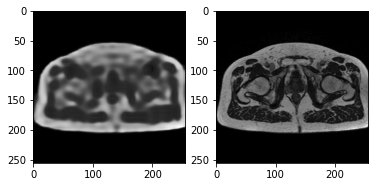

[Validation] Avg loss = 0.005229192586130042
EarlyStopping counter: 1 out of 30


Epoch 49/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00409]


[Training] Avg loss = 0.004810968852494525


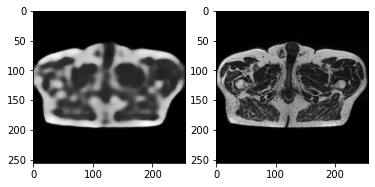

[Validation] Avg loss = 0.005172408134415254
EarlyStopping counter: 2 out of 30


Epoch 50/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00526]


[Training] Avg loss = 0.004794616871935806


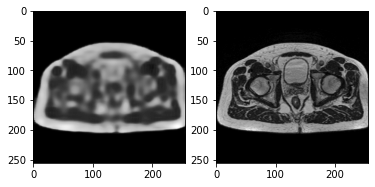

[Validation] Avg loss = 0.005170714251524938
Validation loss decreased (0.005172 --> 0.005171).  Saving model ...


Epoch 51/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00898]


[Training] Avg loss = 0.004817600582839978


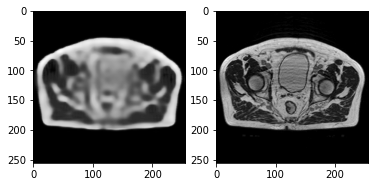

[Validation] Avg loss = 0.005287946666753774
EarlyStopping counter: 1 out of 30


Epoch 52/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.0046] 


[Training] Avg loss = 0.004828603582327387


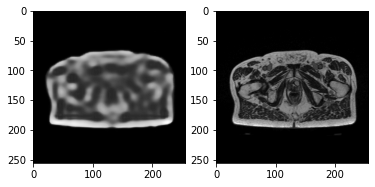

[Validation] Avg loss = 0.005172246967199513
EarlyStopping counter: 2 out of 30


Epoch 53/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00542]


[Training] Avg loss = 0.004804264410155901


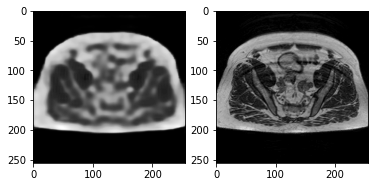

[Validation] Avg loss = 0.005194006272570135
EarlyStopping counter: 3 out of 30


Epoch 54/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00486]


[Training] Avg loss = 0.00481425482161293


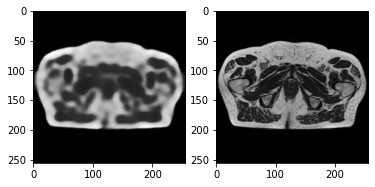

[Validation] Avg loss = 0.005221732727654598
EarlyStopping counter: 4 out of 30


Epoch 55/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00422]


[Training] Avg loss = 0.004828613796109732


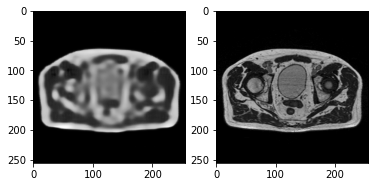

[Validation] Avg loss = 0.005208723196335654
EarlyStopping counter: 5 out of 30


Epoch 56/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00459]


[Training] Avg loss = 0.004823225977166252


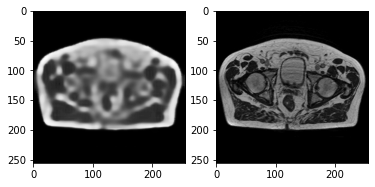

[Validation] Avg loss = 0.005192746900071208
Epoch    56: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 6 out of 30


Epoch 57/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00495]


[Training] Avg loss = 0.004823223224393648


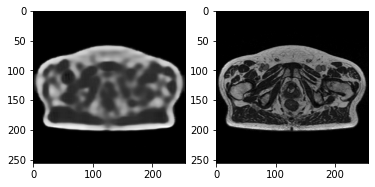

[Validation] Avg loss = 0.005163753569654801
Validation loss decreased (0.005171 --> 0.005164).  Saving model ...


Epoch 58/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00475]


[Training] Avg loss = 0.004822201396141531


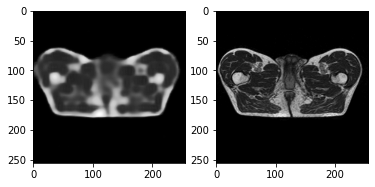

[Validation] Avg loss = 0.005209677879584849
EarlyStopping counter: 1 out of 30


Epoch 59/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00736]


[Training] Avg loss = 0.004808915769347602


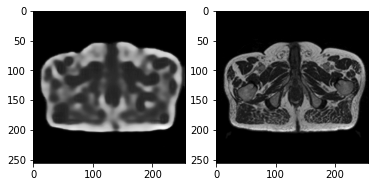

[Validation] Avg loss = 0.005207393240804474
EarlyStopping counter: 2 out of 30


Epoch 60/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00393]


[Training] Avg loss = 0.004830573614549063


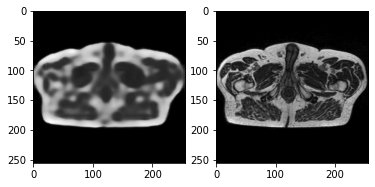

[Validation] Avg loss = 0.00539099140762791
EarlyStopping counter: 3 out of 30


Epoch 61/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00503]


[Training] Avg loss = 0.004807437607895454


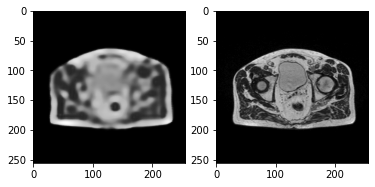

[Validation] Avg loss = 0.005200338439259789
EarlyStopping counter: 4 out of 30


Epoch 62/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.0047] 


[Training] Avg loss = 0.004805719000699305


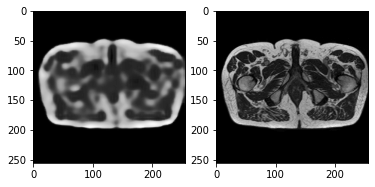

[Validation] Avg loss = 0.0052096153203729945
EarlyStopping counter: 5 out of 30


Epoch 63/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00486]


[Training] Avg loss = 0.004817738686610026


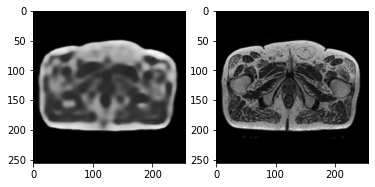

[Validation] Avg loss = 0.005261804994576835
EarlyStopping counter: 6 out of 30


Epoch 64/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00383]


[Training] Avg loss = 0.00480488839706308


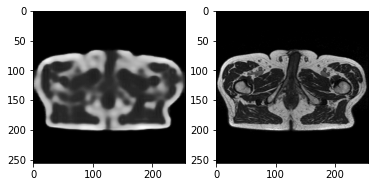

[Validation] Avg loss = 0.005232671715269978
EarlyStopping counter: 7 out of 30


Epoch 65/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00521]


[Training] Avg loss = 0.004809404541357668


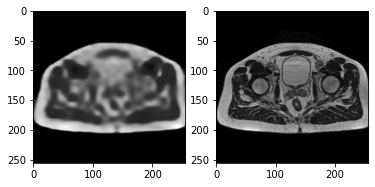

[Validation] Avg loss = 0.005201770572096306
EarlyStopping counter: 8 out of 30


Epoch 66/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00484]


[Training] Avg loss = 0.004820823688206053


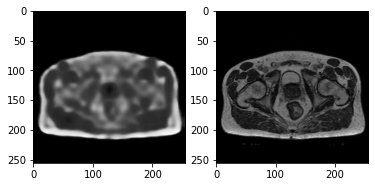

[Validation] Avg loss = 0.005246654411058615
EarlyStopping counter: 9 out of 30


Epoch 67/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00607]


[Training] Avg loss = 0.004821624399568522


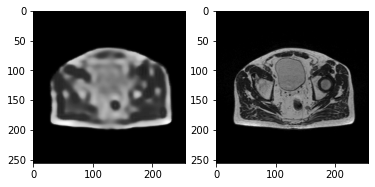

[Validation] Avg loss = 0.00546709860739584
EarlyStopping counter: 10 out of 30


Epoch 68/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.0045] 


[Training] Avg loss = 0.0048139657053996344


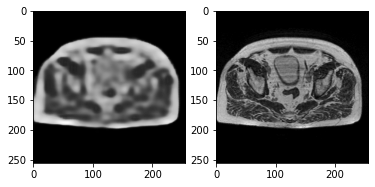

[Validation] Avg loss = 0.005245162770397986
EarlyStopping counter: 11 out of 30


Epoch 69/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00507]


[Training] Avg loss = 0.0048110141608684685


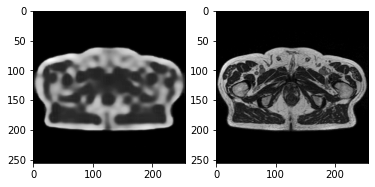

[Validation] Avg loss = 0.00522273879117108
EarlyStopping counter: 12 out of 30


Epoch 70/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00523]


[Training] Avg loss = 0.004814611445937185


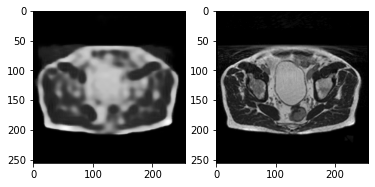

[Validation] Avg loss = 0.0051967462773739115
EarlyStopping counter: 13 out of 30


Epoch 71/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00424]


[Training] Avg loss = 0.004828921263184386


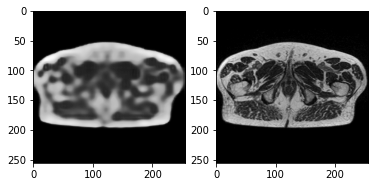

[Validation] Avg loss = 0.005174735173730567
EarlyStopping counter: 14 out of 30


Epoch 72/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.10img/s, loss (batch)=0.00597]


[Training] Avg loss = 0.004810009438759352


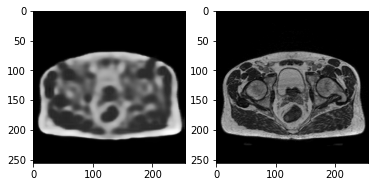

[Validation] Avg loss = 0.005212656767860596
EarlyStopping counter: 15 out of 30


Epoch 73/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00522]


[Training] Avg loss = 0.004806079315115497


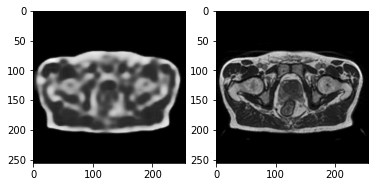

[Validation] Avg loss = 0.005207068311425522
EarlyStopping counter: 16 out of 30


Epoch 74/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00454]


[Training] Avg loss = 0.004805939583616772


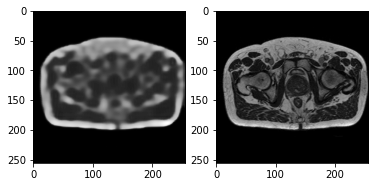

[Validation] Avg loss = 0.005220666347938304
EarlyStopping counter: 17 out of 30


Epoch 75/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.0053] 


[Training] Avg loss = 0.004809886945853758


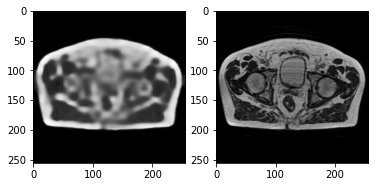

[Validation] Avg loss = 0.005172330056234162
EarlyStopping counter: 18 out of 30


Epoch 76/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00501]


[Training] Avg loss = 0.004807877542048459


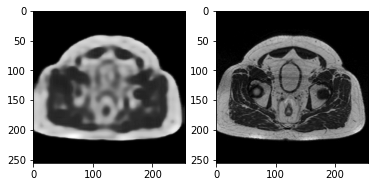

[Validation] Avg loss = 0.005162635025116477
Validation loss decreased (0.005164 --> 0.005163).  Saving model ...


Epoch 77/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.09img/s, loss (batch)=0.00576]


[Training] Avg loss = 0.004834219936410764


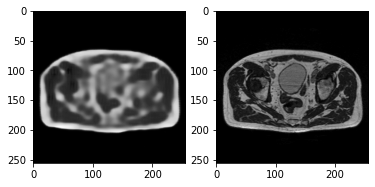

[Validation] Avg loss = 0.0051668538333903445
EarlyStopping counter: 1 out of 30


Epoch 78/200: 100%|█████████▉| 892/893 [02:55<00:00,  5.10img/s, loss (batch)=0.00542]


[Training] Avg loss = 0.004815315715353289


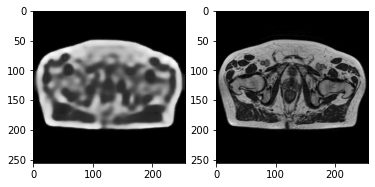

[Validation] Avg loss = 0.005190926308900413
EarlyStopping counter: 2 out of 30


Epoch 79/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00437]


[Training] Avg loss = 0.004817190715388164


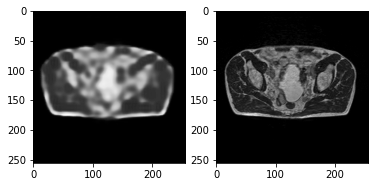

[Validation] Avg loss = 0.005157991421559561
Validation loss decreased (0.005163 --> 0.005158).  Saving model ...


Epoch 80/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00436]


[Training] Avg loss = 0.004800418706523194


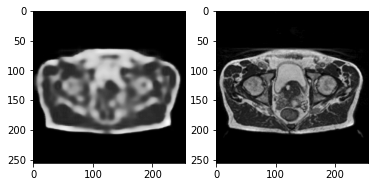

[Validation] Avg loss = 0.005226504309686891
EarlyStopping counter: 1 out of 30


Epoch 81/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00591]


[Training] Avg loss = 0.004817503164204261


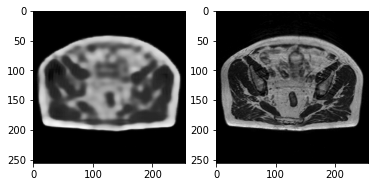

[Validation] Avg loss = 0.005188820386465283
EarlyStopping counter: 2 out of 30


Epoch 82/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.0056] 


[Training] Avg loss = 0.00480496871059871


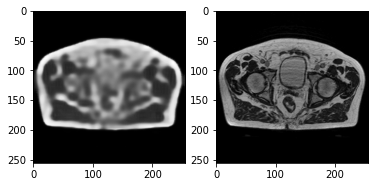

[Validation] Avg loss = 0.005260404683465119
EarlyStopping counter: 3 out of 30


Epoch 83/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00623]


[Training] Avg loss = 0.004809739887881252


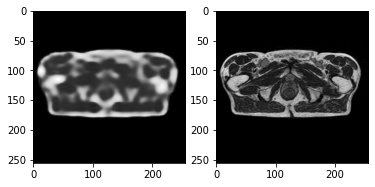

[Validation] Avg loss = 0.005250307737477739
EarlyStopping counter: 4 out of 30


Epoch 84/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00525]


[Training] Avg loss = 0.004801469556736986


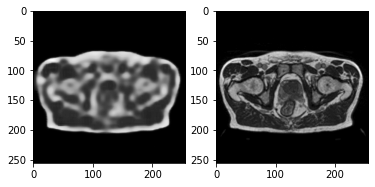

[Validation] Avg loss = 0.005239476907764724
EarlyStopping counter: 5 out of 30


Epoch 85/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00549]


[Training] Avg loss = 0.004810079163584904


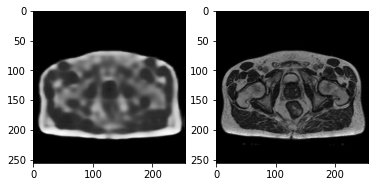

[Validation] Avg loss = 0.00515582155599182
Validation loss decreased (0.005158 --> 0.005156).  Saving model ...


Epoch 86/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00493]


[Training] Avg loss = 0.004803624583725283


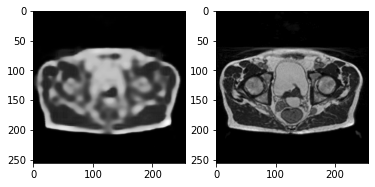

[Validation] Avg loss = 0.005179156865094706
EarlyStopping counter: 1 out of 30


Epoch 87/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00635]


[Training] Avg loss = 0.0048151120550258865


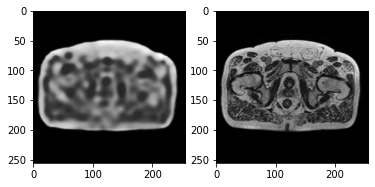

[Validation] Avg loss = 0.005256484525444189
EarlyStopping counter: 2 out of 30


Epoch 88/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00623]


[Training] Avg loss = 0.004823717445631544


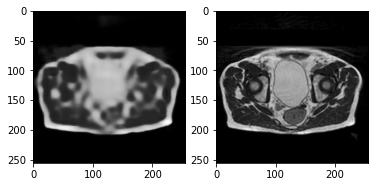

[Validation] Avg loss = 0.005178899027056771
EarlyStopping counter: 3 out of 30


Epoch 89/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00375]


[Training] Avg loss = 0.004809165265502915


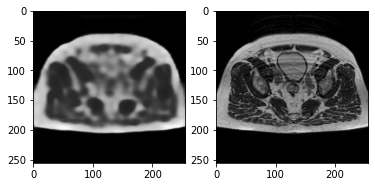

[Validation] Avg loss = 0.0052174962903357575
EarlyStopping counter: 4 out of 30


Epoch 90/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.0036] 


[Training] Avg loss = 0.00479242617362424


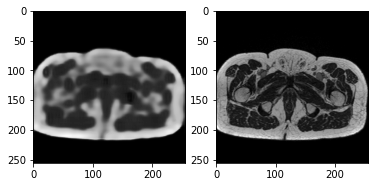

[Validation] Avg loss = 0.005210927063629966
EarlyStopping counter: 5 out of 30


Epoch 91/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00534]


[Training] Avg loss = 0.004819882255097619


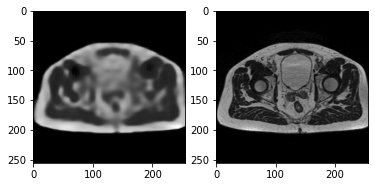

[Validation] Avg loss = 0.005199336107949367
EarlyStopping counter: 6 out of 30


Epoch 92/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00489]


[Training] Avg loss = 0.004800953611591779


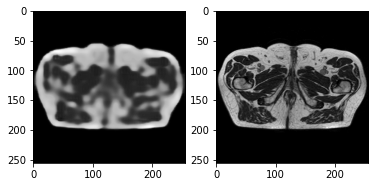

[Validation] Avg loss = 0.005171700776477803
EarlyStopping counter: 7 out of 30


Epoch 93/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00407]


[Training] Avg loss = 0.00479874098391876


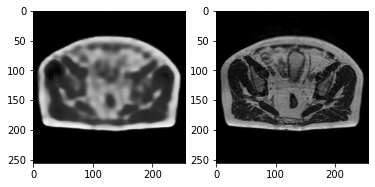

[Validation] Avg loss = 0.005178544588122677
EarlyStopping counter: 8 out of 30


Epoch 94/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00539]


[Training] Avg loss = 0.00483038628521852


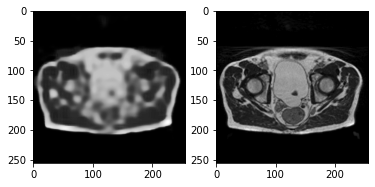

[Validation] Avg loss = 0.005226958444704711
EarlyStopping counter: 9 out of 30


Epoch 95/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00441]


[Training] Avg loss = 0.0048214236554905586


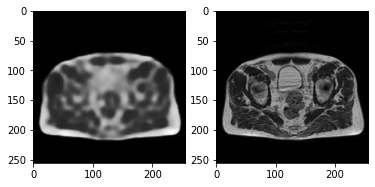

[Validation] Avg loss = 0.00518966111025647
EarlyStopping counter: 10 out of 30


Epoch 96/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00467]


[Training] Avg loss = 0.0048186584753333725


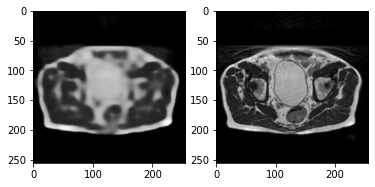

[Validation] Avg loss = 0.005175297568081924
EarlyStopping counter: 11 out of 30


Epoch 97/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00491]


[Training] Avg loss = 0.0047890685969590304


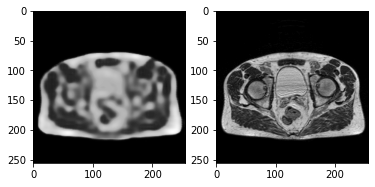

[Validation] Avg loss = 0.0051894269195130165
EarlyStopping counter: 12 out of 30


Epoch 98/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00526]


[Training] Avg loss = 0.004797848654610562


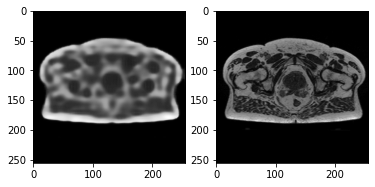

[Validation] Avg loss = 0.005176571688058451
EarlyStopping counter: 13 out of 30


Epoch 99/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00737]


[Training] Avg loss = 0.004811172704196724


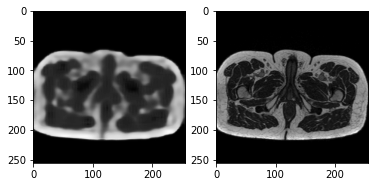

[Validation] Avg loss = 0.005231482837435239
EarlyStopping counter: 14 out of 30


Epoch 100/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00487]


[Training] Avg loss = 0.00480541253899415


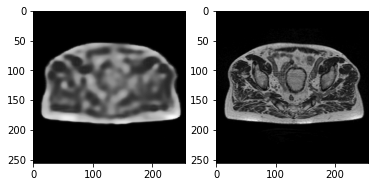

[Validation] Avg loss = 0.00516613673806043
EarlyStopping counter: 15 out of 30


Epoch 101/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00667]


[Training] Avg loss = 0.004824448385498041


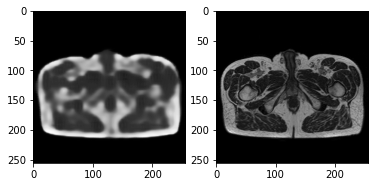

[Validation] Avg loss = 0.005214737415491994
EarlyStopping counter: 16 out of 30


Epoch 102/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00462]


[Training] Avg loss = 0.004816177481272303


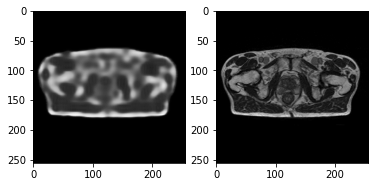

[Validation] Avg loss = 0.005184058813845413
EarlyStopping counter: 17 out of 30


Epoch 103/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00461]


[Training] Avg loss = 0.004812034949595641


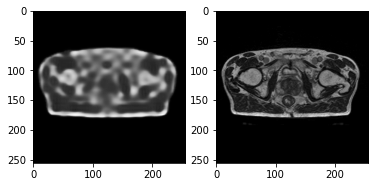

[Validation] Avg loss = 0.005165188015429395
EarlyStopping counter: 18 out of 30


Epoch 104/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.11img/s, loss (batch)=0.00561]


[Training] Avg loss = 0.004817091301657168


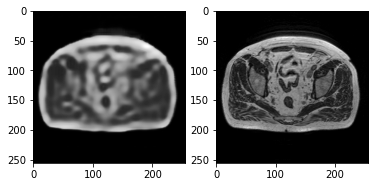

[Validation] Avg loss = 0.0052941379954933926
EarlyStopping counter: 19 out of 30


Epoch 105/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00454]


[Training] Avg loss = 0.00480956024196195


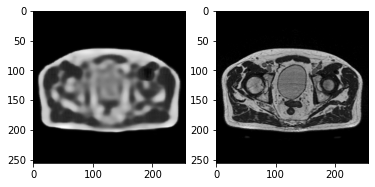

[Validation] Avg loss = 0.005234379279842176
EarlyStopping counter: 20 out of 30


Epoch 106/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00557]


[Training] Avg loss = 0.00481709143019637


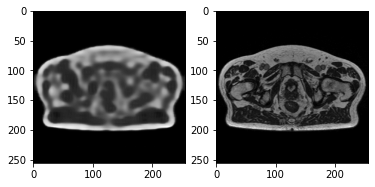

[Validation] Avg loss = 0.005180076649873563
EarlyStopping counter: 21 out of 30


Epoch 107/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00569]


[Training] Avg loss = 0.004828162673570858


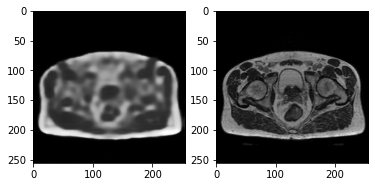

[Validation] Avg loss = 0.0051845833228858
EarlyStopping counter: 22 out of 30


Epoch 108/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00409]


[Training] Avg loss = 0.004808976295407265


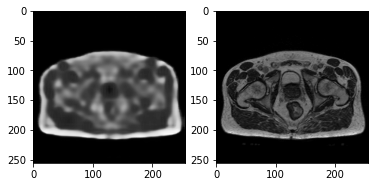

[Validation] Avg loss = 0.005164569260693914
EarlyStopping counter: 23 out of 30


Epoch 109/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.0033] 


[Training] Avg loss = 0.004802200018687952


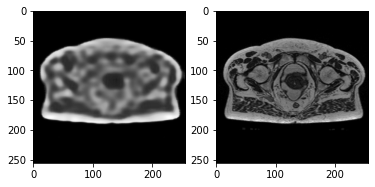

[Validation] Avg loss = 0.005174429331085469
EarlyStopping counter: 24 out of 30


Epoch 110/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00386]


[Training] Avg loss = 0.0047948838228282645


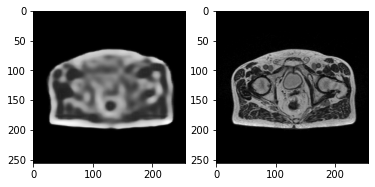

[Validation] Avg loss = 0.005211472090198459
EarlyStopping counter: 25 out of 30


Epoch 111/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00623]


[Training] Avg loss = 0.0048158948892708725


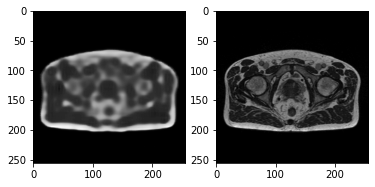

[Validation] Avg loss = 0.0051709029380932895
EarlyStopping counter: 26 out of 30


Epoch 112/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00474]


[Training] Avg loss = 0.004777627780695612


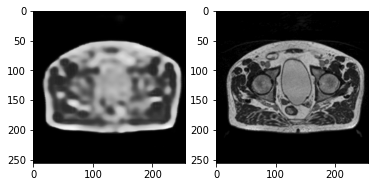

[Validation] Avg loss = 0.005161470739730317
EarlyStopping counter: 27 out of 30


Epoch 113/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00434]


[Training] Avg loss = 0.004816706145019558


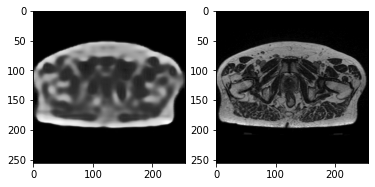

[Validation] Avg loss = 0.005168992386694395
EarlyStopping counter: 28 out of 30


Epoch 114/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00423]


[Training] Avg loss = 0.0048095162773832325


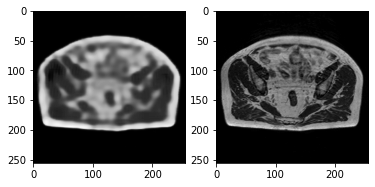

[Validation] Avg loss = 0.005180785360995053
EarlyStopping counter: 29 out of 30


Epoch 115/200: 100%|█████████▉| 892/893 [02:54<00:00,  5.12img/s, loss (batch)=0.00458]


[Training] Avg loss = 0.004794844398056006


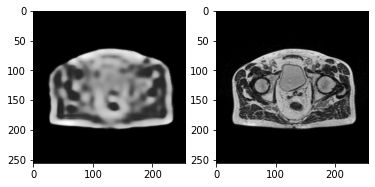

[Validation] Avg loss = 0.005190592202305696
EarlyStopping counter: 30 out of 30
early_stopping


In [9]:
def train_model(model,train_loader, val_loader):
    for epoch in range(NUM_EPOCHS):
        epoch_train(model,train_loader,val_loader, epoch)
        if early_stopping.early_stop:
            print("early_stopping")
            break

train_model(unet,train_loader,valid_loader)